### Installing importing libraries

In [47]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import random
import seaborn as sns
import mplfinance as mpf

### Downloading historical and economic indicators

In [48]:
# Define the date range
start_date = "2015-01-01"
end_date = "2024-08-01"

# Fetch historical data for FTSE 250
ftse_250_data = yf.download("^FTMC", start=start_date, end=end_date).reset_index()
ftse_250_data['Date'] = ftse_250_data['Date'].dt.date

# Fetch macroeconomic data
gdp_data = web.DataReader('UKNGDP', 'fred', start=start_date, end=end_date).reset_index()
gdp_data['DATE'] = gdp_data['DATE'].dt.date

interest_rate_data = web.DataReader('IRLTLT01GBM156N', 'fred', start=start_date, end=end_date).reset_index()
interest_rate_data['DATE'] = interest_rate_data['DATE'].dt.date

inflation_data = web.DataReader('CPGRLE01GBM659N', 'fred', start=start_date, end=end_date).reset_index()
inflation_data['DATE'] = inflation_data['DATE'].dt.date

unemployment_data = web.DataReader('LRUN64TTGBQ156S', 'fred', start=start_date, end=end_date).reset_index()
unemployment_data['DATE'] = unemployment_data['DATE'].dt.date

# Display the data
print("FTSE 250 Data:")
print(ftse_250_data.head())

print("\nGDP Data:")
print(gdp_data.head())

print("\nInterest Rate Data:")
print(interest_rate_data.head())

print("\nInflation Data:")
print(inflation_data.head())

print("\nUnemployment Data:")
print(unemployment_data.head())

[*********************100%%**********************]  1 of 1 completed


FTSE 250 Data:
         Date          Open          High           Low         Close  \
0  2015-01-02  16085.400391  16103.099609  15977.700195  16052.000000   
1  2015-01-05  16052.000000  16141.400391  15910.500000  15921.700195   
2  2015-01-06  15921.700195  15980.200195  15778.400391  15778.700195   
3  2015-01-07  15778.700195  15924.200195  15778.700195  15851.700195   
4  2015-01-08  15851.700195  16086.500000  15851.700195  16085.500000   

      Adj Close     Volume  
0  16052.000000  126821600  
1  15921.700195  211207200  
2  15778.700195  250197700  
3  15851.700195  250241800  
4  16085.500000  259066600  

GDP Data:
         DATE  UKNGDP
0  2015-01-01  474738
1  2015-04-01  476582
2  2015-07-01  479885
3  2015-10-01  485246
4  2016-01-01  489730

Interest Rate Data:
         DATE  IRLTLT01GBM156N
0  2015-01-01           1.5890
1  2015-02-01           1.7365
2  2015-03-01           1.7941
3  2015-04-01           1.7550
4  2015-05-01           2.0243

Inflation Data:
     

### Pre-processing of data

In [49]:
# Changing the column names 
interest_rate_data.rename(columns={'DATE': 'Date',
                                   'IRLTLT01GBM156N':'interest_rate'}, inplace=True)
inflation_data.rename(columns={'DATE': 'Date',
                               'CPGRLE01GBM659N': 'inflation'}, inplace=True)
unemployment_data.rename(columns={'DATE': 'Date',
                                  'LRUN64TTGBQ156S':'unemployment_rate'}, inplace=True)
gdp_data.rename(columns={'DATE': 'Date',
                         'UKNGDP':'gdp'}, inplace=True)

print(interest_rate_data.head(1))
print(inflation_data.head(1))
print(unemployment_data.head(1))
print(gdp_data.head(1))

         Date  interest_rate
0  2015-01-01          1.589
         Date  inflation
0  2015-01-01        1.5
         Date  unemployment_rate
0  2015-01-01           5.714825
         Date     gdp
0  2015-01-01  474738


In [50]:
# Creating an empty DataFrame to store daily data
daily_gdp_data = pd.DataFrame()

# Loop over each row in the quarterly GDP DataFrame
for _, row in gdp_data.iterrows():
    # Get the start date for the quarter
    start_date = row['Date']

    # Calculate the end date of the quarter
    end_date = start_date + pd.offsets.QuarterEnd(0)

    # Create a date range for all days in the quarter
    date_range = pd.date_range(start=start_date, end=end_date)

    # Repeat the GDP value for each day in the quarter
    temp_df = pd.DataFrame({'Date': date_range, 'gdp': row['gdp']})

    # Append to the daily DataFrame
    daily_gdp_data = pd.concat([daily_gdp_data, temp_df])

# Reset index
daily_gdp_data = daily_gdp_data.reset_index(drop=True)

# Display the daily GDP data
print(daily_gdp_data)

           Date     gdp
0    2015-01-01  474738
1    2015-01-02  474738
2    2015-01-03  474738
3    2015-01-04  474738
4    2015-01-05  474738
...         ...     ...
3373 2024-03-27  688138
3374 2024-03-28  688138
3375 2024-03-29  688138
3376 2024-03-30  688138
3377 2024-03-31  688138

[3378 rows x 2 columns]


In [51]:
# Creating an empty DataFrame to store daily data
daily_interest_rate_data = pd.DataFrame()

# Loop over each row in the monthly unemployment rate DataFrame
for _, row in interest_rate_data.iterrows():
    # Get the start date for the month
    start_date = row['Date']

    # Calculate the end date of the month
    end_date = start_date + pd.offsets.MonthEnd(0)

    # Create a date range for all days in the month
    date_range = pd.date_range(start=start_date, end=end_date)

    # Repeat the unemployment rate value for each day in the month
    temp_df = pd.DataFrame({'Date': date_range, 'interest_rate': row['interest_rate']})

    # Append to the daily DataFrame
    daily_interest_rate_data = pd.concat([daily_interest_rate_data, temp_df])

# Reset index if necessary
daily_interest_rate_data = daily_interest_rate_data.reset_index(drop=True)

# Display the daily unemployment rate data
print(daily_interest_rate_data)

           Date  interest_rate
0    2015-01-01         1.5890
1    2015-01-02         1.5890
2    2015-01-03         1.5890
3    2015-01-04         1.5890
4    2015-01-05         1.5890
...         ...            ...
3464 2024-06-26         4.1644
3465 2024-06-27         4.1644
3466 2024-06-28         4.1644
3467 2024-06-29         4.1644
3468 2024-06-30         4.1644

[3469 rows x 2 columns]


In [52]:
# Create an empty DataFrame to store daily data
daily_inflation_data = pd.DataFrame()

# Loop over each row in the monthly unemployment rate DataFrame
for _, row in inflation_data.iterrows():
    # Get the start date for the month
    start_date = row['Date']

    # Calculate the end date of the month
    end_date = start_date + pd.offsets.MonthEnd(0)

    # Create a date range for all days in the month
    date_range = pd.date_range(start=start_date, end=end_date)

    # Repeat the unemployment rate value for each day in the month
    temp_df = pd.DataFrame({'Date': date_range, 'inflation': row['inflation']})

    # Append to the daily DataFrame
    daily_inflation_data = pd.concat([daily_inflation_data, temp_df])

# Reset index if necessary
daily_inflation_data = daily_inflation_data.reset_index(drop=True)

# Display the daily unemployment rate data
print(daily_inflation_data)

           Date  inflation
0    2015-01-01        1.5
1    2015-01-02        1.5
2    2015-01-03        1.5
3    2015-01-04        1.5
4    2015-01-05        1.5
...         ...        ...
3464 2024-06-26        4.2
3465 2024-06-27        4.2
3466 2024-06-28        4.2
3467 2024-06-29        4.2
3468 2024-06-30        4.2

[3469 rows x 2 columns]


In [53]:
# Creating an empty DataFrame to store daily data
daily_unemployment_data = pd.DataFrame()

# Loop over each row in the monthly unemployment rate DataFrame
for _, row in unemployment_data.iterrows():
    # Get the start date for the month
    start_date = row['Date']

    # Calculate the end date of the month
    end_date = start_date + pd.offsets.QuarterEnd(0)

    # Create a date range for all days in the month
    date_range = pd.date_range(start=start_date, end=end_date)

    # Repeat the unemployment rate value for each day in the month
    temp_df = pd.DataFrame({'Date': date_range, 'unemployment_rate': row['unemployment_rate']})

    # Append to the daily DataFrame
    daily_unemployment_data = pd.concat([daily_unemployment_data, temp_df])

# Reset index if necessary
daily_unemployment_data = daily_unemployment_data.reset_index(drop=True)

# Display the daily unemployment rate data
print(daily_unemployment_data)

           Date  unemployment_rate
0    2015-01-01           5.714825
1    2015-01-02           5.714825
2    2015-01-03           5.714825
3    2015-01-04           5.714825
4    2015-01-05           5.714825
...         ...                ...
3464 2024-06-26           4.243783
3465 2024-06-27           4.243783
3466 2024-06-28           4.243783
3467 2024-06-29           4.243783
3468 2024-06-30           4.243783

[3469 rows x 2 columns]


In [54]:
# Converting the 'Date' column in interest_rate_data to datetime64[ns]
daily_interest_rate_data['Date'] = pd.to_datetime(daily_interest_rate_data['Date'])
ftse_250_data['Date'] = pd.to_datetime(ftse_250_data['Date'])
merge_data = pd.merge(ftse_250_data, daily_interest_rate_data, on='Date', how='left')

# Merging data on the 'Date' column
merge_data = pd.merge(merge_data, daily_gdp_data, on='Date', how='left')
merge_data = pd.merge(merge_data, daily_inflation_data, on='Date', how='left')
merge_data = pd.merge(merge_data, daily_unemployment_data, on='Date', how='left')

# Set 'Date' back to index
merge_data.set_index('Date', inplace=True)

# Display the combined dataset
print(merge_data.tail())

                    Open          High           Low         Close  \
Date                                                                 
2024-07-25  20950.800781  20951.500000  20699.099609  20884.400391   
2024-07-26  20884.400391  21360.500000  20856.500000  21356.300781   
2024-07-29  21356.300781  21490.300781  21221.099609  21252.099609   
2024-07-30  21252.099609  21508.800781  21195.400391  21432.500000   
2024-07-31  21432.500000  21649.500000  21430.099609  21600.699219   

               Adj Close     Volume  interest_rate  gdp  inflation  \
Date                                                                 
2024-07-25  20884.400391  252681300            NaN  NaN        NaN   
2024-07-26  21356.300781  264561800            NaN  NaN        NaN   
2024-07-29  21252.099609  239958100            NaN  NaN        NaN   
2024-07-30  21432.500000  305575900            NaN  NaN        NaN   
2024-07-31  21600.699219  309322400            NaN  NaN        NaN   

            unempl

In [55]:
# copy merged data to new data frame 
data = merge_data.copy()

In [56]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,interest_rate,gdp,inflation,unemployment_rate
count,2420.000000,2420.000000,2420.000000,2420.000000,2420.000000,2.420000e+03,2397.000000,2335.000000,2397.000000,2397.000000
mean,19225.781415,19333.269928,19120.492558,19228.122904,19228.122904,3.101067e+08,1.739999,557934.220128,2.734001,4.547958
std,1852.486749,1843.673716,1864.133076,1852.075271,1852.075271,1.160528e+08,1.211523,62679.745570,1.667493,0.545788
min,12829.700195,13035.099609,12373.500000,12829.700195,12829.700195,0.000000e+00,0.209400,474738.000000,1.000000,3.831278
25%,17753.524902,17841.699707,17638.399902,17754.875488,17754.875488,2.492754e+08,0.854900,513926.000000,1.500000,4.106920
50%,19263.849609,19352.850586,19165.750000,19264.399414,19264.399414,2.953385e+08,1.393100,540123.000000,1.800000,4.366892
75%,20304.600586,20419.800781,20222.749512,20307.024902,20307.024902,3.484252e+08,1.979900,596674.000000,4.200000,5.030393
max,24250.800781,24353.900391,24176.300781,24250.800781,24250.800781,1.231878e+09,4.569500,688138.000000,6.500000,5.780764


In [57]:
# Fill missing values column-wise using forward fill
data = data.ffill()

In [58]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume,interest_rate,gdp,inflation,unemployment_rate
Date,,,,,,,,,,
2015-01-02,16085.400391,16103.099609,15977.700195,16052.000000,16052.000000,126821600,1.589,474738.0,1.5,5.714825
2015-01-05,16052.000000,16141.400391,15910.500000,15921.700195,15921.700195,211207200,1.589,474738.0,1.5,5.714825
2015-01-06,15921.700195,15980.200195,15778.400391,15778.700195,15778.700195,250197700,1.589,474738.0,1.5,5.714825
2015-01-07,15778.700195,15924.200195,15778.700195,15851.700195,15851.700195,250241800,1.589,474738.0,1.5,5.714825
2015-01-08,15851.700195,16086.500000,15851.700195,16085.500000,16085.500000,259066600,1.589,474738.0,1.5,5.714825


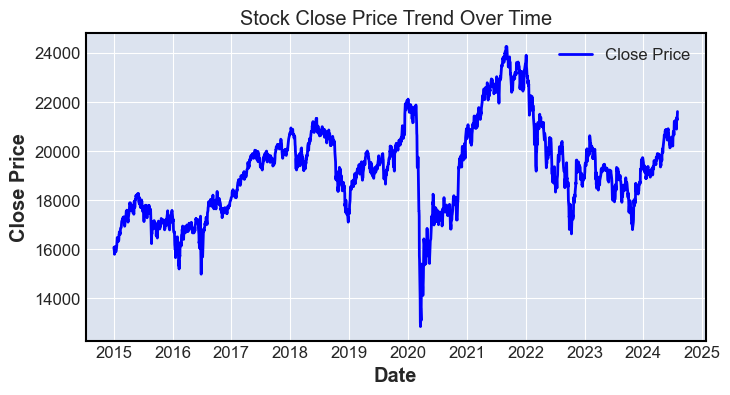

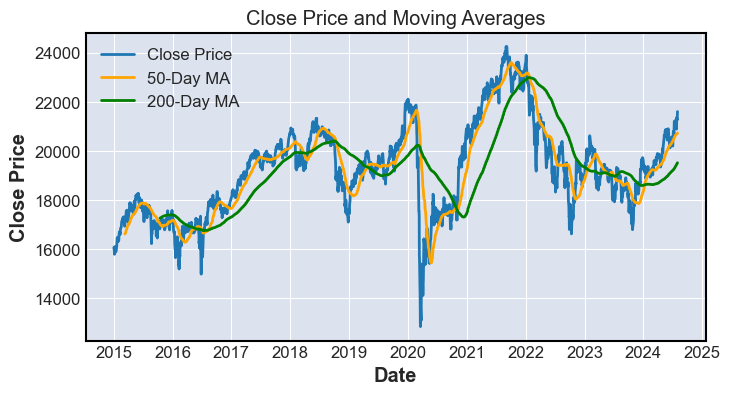

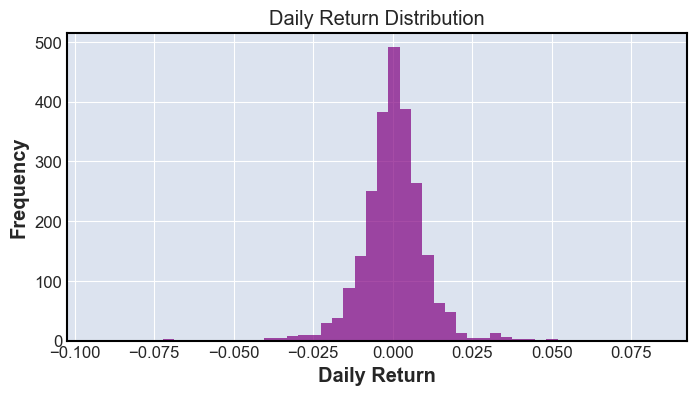

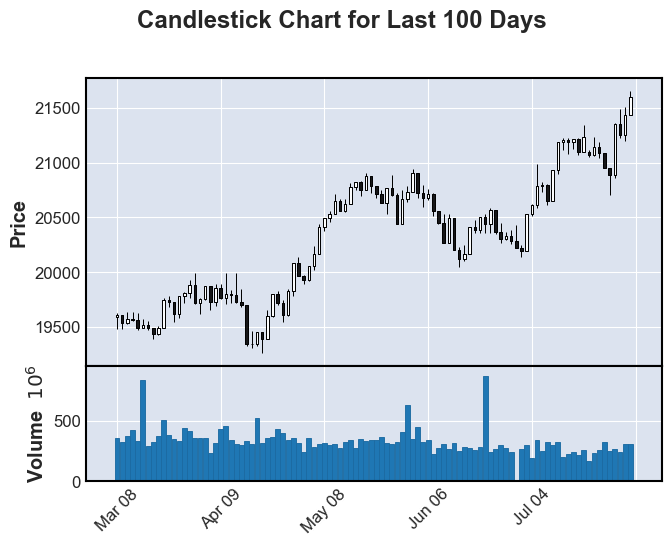

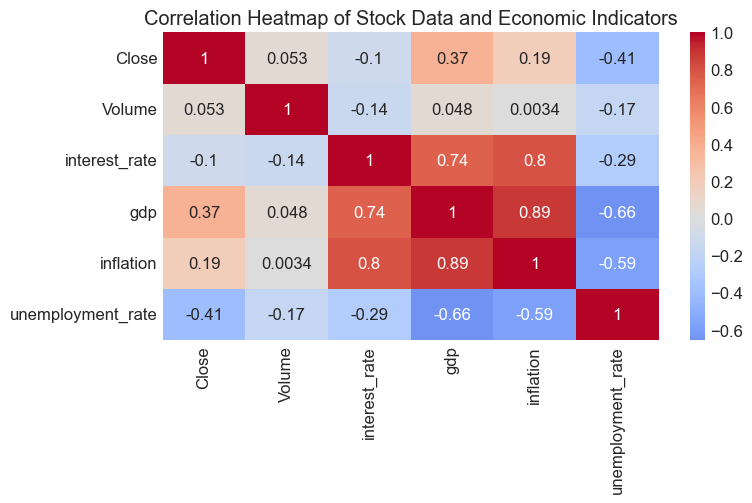

In [62]:


# Assuming you have stock data in 'df'
df = data.reset_index().copy()

# Drop rows with missing data in economic indicators
df_cleaned = df.dropna(subset=['interest_rate', 'gdp', 'inflation', 'unemployment_rate'])

# Summary statistics
summary_stats = df.describe()

# Plot closing price trend
plt.figure(figsize=(8,4))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.title('Stock Close Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Moving averages
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(8,4))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['50_MA'], label='50-Day MA', color='orange')
plt.plot(df['Date'], df['200_MA'], label='200-Day MA', color='green')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Daily returns
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(8,4))
plt.hist(df['Daily_Return'].dropna(), bins=50, color='purple', alpha=0.7)
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Candlestick chart for recent 100 days


df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot candlestick chart
mpf.plot(df[-100:], type='candle', volume=True, title='Candlestick Chart for Last 100 Days')

# Correlation heatmap with economic indicators
plt.figure(figsize=(8,4))
sns.heatmap(df_cleaned[['Close', 'Volume', 'interest_rate', 'gdp', 'inflation', 'unemployment_rate']].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Stock Data and Economic Indicators')
plt.show()

In [63]:
# Check if 'Date' is in the index
if 'Date' in data.index.names:
  print("The index is 'Date'")
else:
  print("The index is not 'Date'")

The index is 'Date'


In [64]:
# Create target variable y
window = 15
data['Target'] = data['Close'].shift(-window)

# Dropping rows with NaN values (as last n rows won't have a target)
data = data.dropna()

### Labelling the data

In [65]:
 # Labelling
def create_dataset_with_macro(data, window=15):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[['Close','interest_rate','gdp','inflation','unemployment_rate']].iloc[i:i+window].values)
        y.append(data['Target'][i])
    return np.array(X), np.array(y)

### Splitting and scaling of the data

In [66]:
# Data Splitting: Train-Test and Validation Split
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)

train_data = data[:train_size]
val_data = data[train_size :train_size+val_size]
test_data = data[train_size+val_size:]

def rolling_min_max_scaling(train_data, val_data, test_data, window=15):
    scaler = MinMaxScaler()
    scaled_train_data = train_data.copy()
    scaled_val_data = val_data.copy()
    scaled_test_data = test_data.copy()

    # Scale training data
    for i in range(len(train_data)):
        start_idx = max(0, i - window + 1)
        end_idx = i + 1
        window_data = train_data[start_idx:end_idx]
        scaled_window = scaler.fit_transform(window_data)
        scaled_train_data.iloc[i] = scaled_window[-1]

    # Scale validation data
    for i in range(len(val_data)):
        start_idx = max(0, len(train_data) - window + 1)
        end_idx = len(train_data) + i + 1
        window_data = np.vstack((train_data[start_idx:], val_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_val_data.iloc[i] = scaled_window[-1]

    # Scale test data
    for i in range(len(test_data)):
        start_idx = max(0, len(train_data) + len(val_data) - window + 1)
        end_idx = len(train_data) + len(val_data) + i + 1
        window_data = np.vstack((train_data[-window:], val_data, test_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_test_data.iloc[i] = scaled_window[-1]

    return scaled_train_data, scaled_val_data, scaled_test_data, scaler


# Apply the scaling, selecting columns by name
selected_columns = ['Close','interest_rate','gdp','inflation','unemployment_rate', 'Target']
scaled_train_data, scaled_val_data, scaled_test_data, scaler = rolling_min_max_scaling(
    train_data[selected_columns],
    val_data[selected_columns],
    test_data[selected_columns]
)

### Model Building

In [67]:
# Set seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [68]:
# Creating datasets
window_size = 15
X_train, y_train = create_dataset_with_macro(scaled_train_data[['Close','interest_rate','gdp','inflation','unemployment_rate', 'Target']], window=window_size)
X_val, y_val = create_dataset_with_macro(scaled_val_data[['Close','interest_rate','gdp','inflation','unemployment_rate', 'Target']], window=window_size)
X_test, y_test = create_dataset_with_macro(scaled_test_data[['Close','interest_rate','gdp','inflation','unemployment_rate', 'Target']], window=window_size)

# Reshaping data for LSTM and CNN
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Display the shapes
print("\nTraining Data Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

# Display the shapes
print("\nTesting Data Shape:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Training Data Shape:
X_train: (1668, 15, 5)
y_train: (1668,)

Testing Data Shape:
X_test: (347, 15, 5)
y_test: (347,)


### CNN Model

In [69]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_train_cnn.shape[2])),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_cnn = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val),epochs=10, batch_size=16, verbose=0)

# Predict with CNN
cnn_predictions_scaled = cnn_model.predict(X_test_cnn)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column

# Reverse Scaling for CNN
cnn_predictions = close_scaler.inverse_transform(cnn_predictions_scaled)

cnn_predictions = cnn_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


### LSTM Model

In [82]:
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 5)),
    Dense(50, activation='relu'),
    Dense(1)
    ])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val),epochs=10, batch_size=16, verbose=0)

# Predict with LSTM
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column

# Reverse Scaling for CNN
lstm_predictions = close_scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions = lstm_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


### ANN Model

In [84]:
ann_model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)),
    Dense(50, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mean_squared_error')
# Reshape X_val to match the input shape of the ANN
history_ann = ann_model.fit(X_train.reshape(X_train.shape[0], -1), y_train,
              validation_data=(X_val.reshape(X_val.shape[0], -1), y_val),
              epochs=15, batch_size=16, verbose=0)

# Predict with ANN
ann_predictions_scaled = ann_model.predict(X_test.reshape(X_test.shape[0], -1))

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column
# Reverse Scaling for ANN
ann_predictions = close_scaler.inverse_transform(ann_predictions_scaled)

ann_predictions = ann_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Plot training & validation loss values

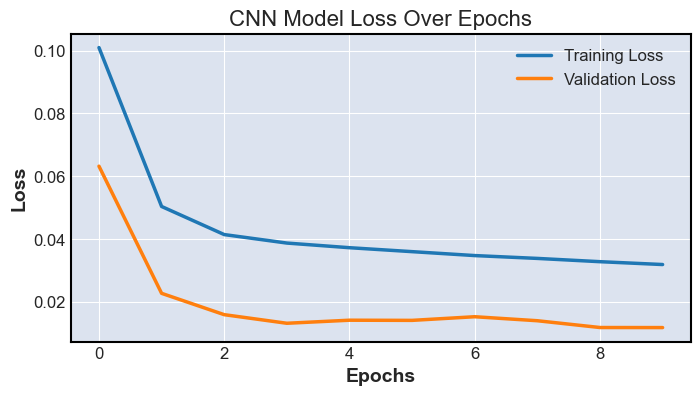

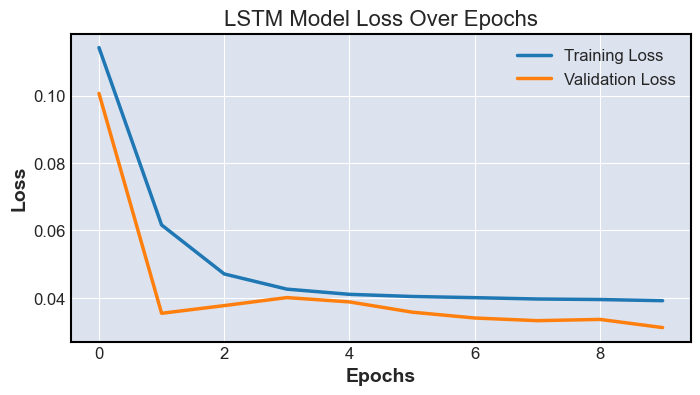

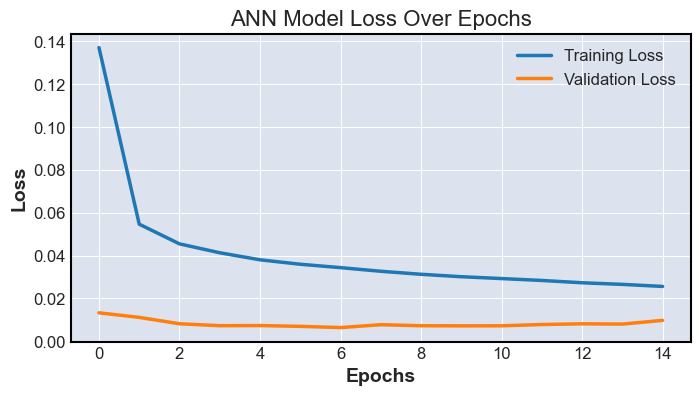

In [86]:
# CNN Plot
plt.figure(figsize=(8, 4))
plt.plot(history_cnn.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('CNN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

#LSTM Plot
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('LSTM Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

# ANN Plot
plt.figure(figsize=(8, 4))
plt.plot(history_ann.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_ann.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('ANN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

### Model evaluation

CNN - MAE: 545.59, MSE: 392980.45, RMSE: 626.88
LSTM - MAE: 1192.10, MSE: 1475242.79, RMSE: 1214.60
ANN - MAE: 537.04, MSE: 387590.51, RMSE: 622.57


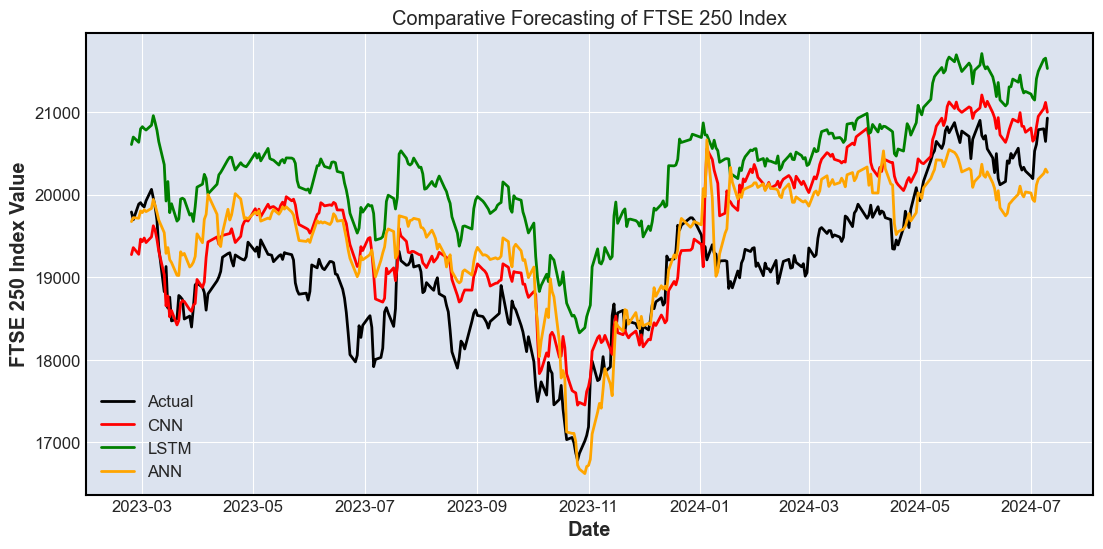

In [92]:
def evaluate_model(true_values, predictions, model_name):
    # Ensure predictions and true values have the same length for comparison
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions) # Now compares arrays of the same length
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Evaluate models on test data, ensuring consistent lengths
evaluate_model(test_data['Target'], cnn_predictions, "CNN")
evaluate_model(test_data['Target'], lstm_predictions, "LSTM")
evaluate_model(test_data['Target'], ann_predictions, "ANN")

# Comparative Analysis
plt.figure(figsize=(13, 6))

# Adjust the slicing of arima_forecast to match the length of test_data['Close'][window_size:]
plt.plot(test_data.index[window_size:], test_data['Close'][window_size:], label='Actual', color='black')
plt.plot(test_data.index[window_size:], cnn_predictions, label='CNN', color='red')
plt.plot(test_data.index[window_size:], lstm_predictions, label='LSTM', color='green')
plt.plot(test_data.index[window_size:], ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')
plt.legend()
plt.show()

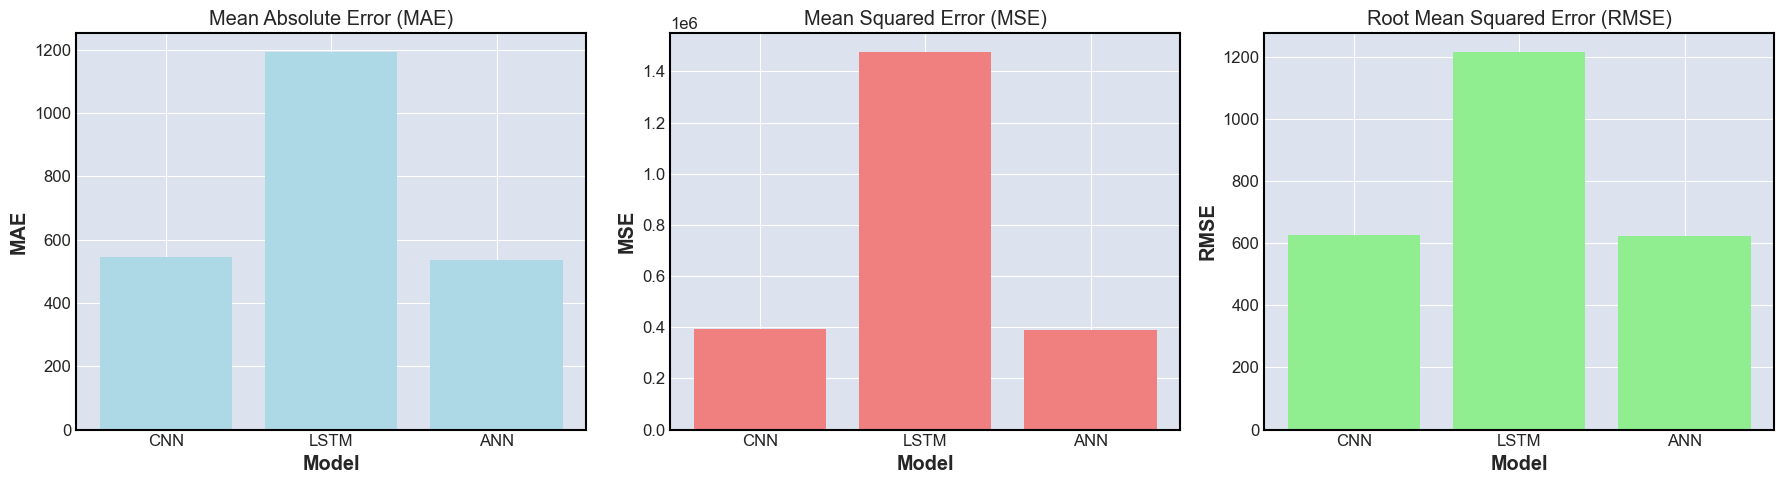

In [88]:
def evaluate_model(true_values, predictions):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]
    
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Assuming you have the true values and predictions for each model
true_values = test_data['Close'][window_size:]
models_predictions = {
    'CNN': cnn_predictions,
    'LSTM': lstm_predictions,
    'ANN': ann_predictions
}

# Compute metrics for each model
metrics = {model: evaluate_model(true_values, preds) for model, preds in models_predictions.items()}

# Prepare data for plotting
models = list(metrics.keys())
mae_values = [metrics[model][0] for model in models]
mse_values = [metrics[model][1] for model in models]
rmse_values = [metrics[model][2] for model in models]

# Plot MAE, MSE, and RMSE
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].bar(models, mae_values, color='lightblue')
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('MAE')

# MSE
axs[1].bar(models, mse_values, color='lightcoral')
axs[1].set_title('Mean Squared Error (MSE)')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('MSE')

# RMSE
axs[2].bar(models, rmse_values, color='lightgreen')
axs[2].set_title('Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


### Predicting 15th and 30th day from today using predicted data

CNN - MAE: 1366.59, MSE: 2056359.33, RMSE: 1434.00
LSTM - MAE: 403.92, MSE: 223184.37, RMSE: 472.42
ANN - MAE: 900.81, MSE: 924073.08, RMSE: 961.29

Comparison of 15th and 30th Day Predictions with Actual Values:
15th Day (2024-06-18 00:00:00): Actual: 20409.90, CNN: 19314.19, LSTM: 20643.08, ANN: 19692.87
30th Day (2024-07-02 00:00:00): Actual: 20194.50, CNN: 18706.23, LSTM: 19942.52, ANN: 19288.27


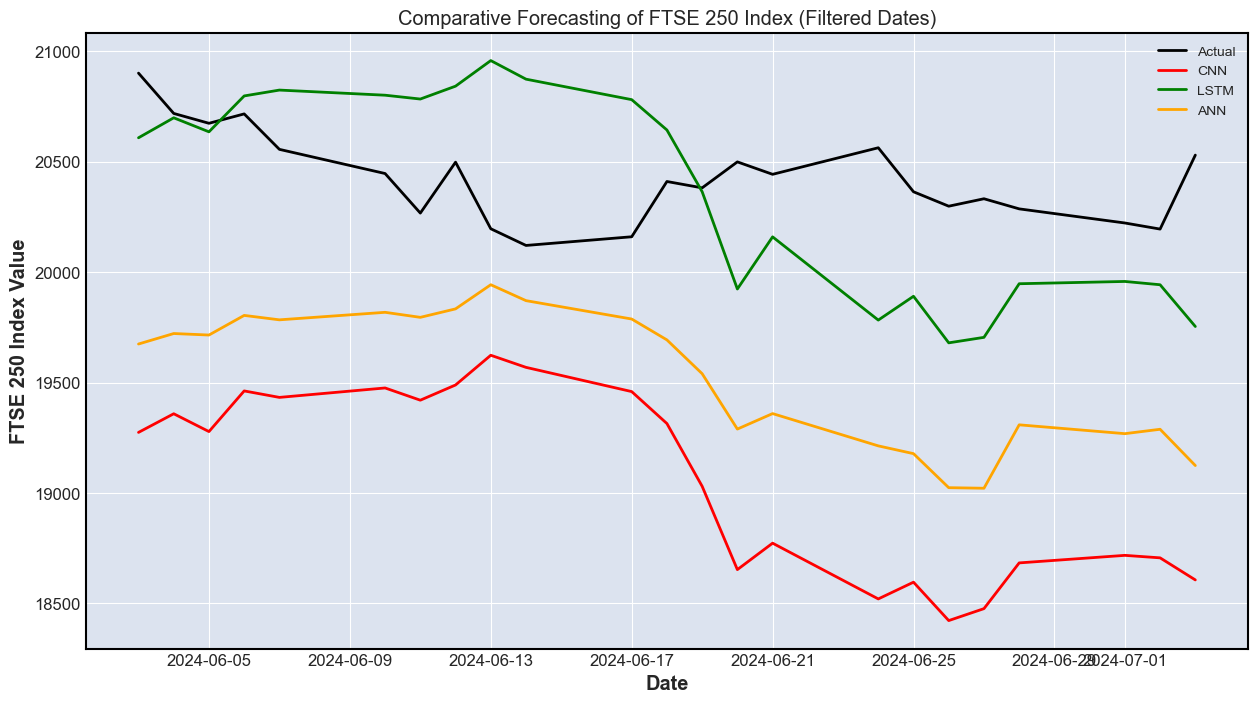

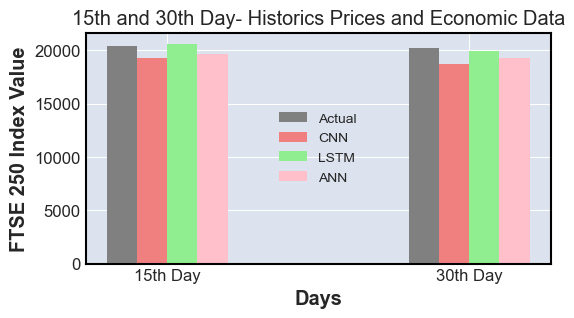

In [91]:
def evaluate_model(true_values, predictions, model_name):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Specify the date range for plotting
start_date = '2024-06-01'
end_date = '2024-07-03'

# Filter the test data for the specified date range
filtered_test_data = test_data.loc[(test_data.index >= start_date) & (test_data.index <= end_date)]

# Get the corresponding index positions from the filtered test data
filtered_indices = filtered_test_data.index.get_indexer(filtered_test_data.index)

# Filter the predictions using these index positions
filtered_cnn_predictions = np.array(cnn_predictions)[filtered_indices]
filtered_lstm_predictions = np.array(lstm_predictions)[filtered_indices]
filtered_ann_predictions = np.array(ann_predictions)[filtered_indices]

# Evaluate models on the filtered test data
evaluate_model(filtered_test_data['Close'], filtered_cnn_predictions, "CNN")
evaluate_model(filtered_test_data['Close'], filtered_lstm_predictions, "LSTM")
evaluate_model(filtered_test_data['Close'], filtered_ann_predictions, "ANN")

# Extracting the 15th and 30th day's actual and predicted values
day_15 = 11  # Index for 15th day (0-based index, so 11 corresponds to 15th day)
day_30 = 21  # Index for 30th day

# Get actual values and predictions for the 15th and 30th day
actual_15 = filtered_test_data['Close'].iloc[day_15]
cnn_15 = filtered_cnn_predictions[day_15]
lstm_15 = filtered_lstm_predictions[day_15]
ann_15 = filtered_ann_predictions[day_15]

actual_30 = filtered_test_data['Close'].iloc[day_30]
cnn_30 = filtered_cnn_predictions[day_30]
lstm_30 = filtered_lstm_predictions[day_30]
ann_30 = filtered_ann_predictions[day_30]

# Print comparison for the 15th and 30th days
print("\nComparison of 15th and 30th Day Predictions with Actual Values:")
print(f"15th Day ({filtered_test_data.index[day_15]}): Actual: {actual_15:.2f}, CNN: {cnn_15:.2f}, LSTM: {lstm_15:.2f}, ANN: {ann_15:.2f}")
print(f"30th Day ({filtered_test_data.index[day_30]}): Actual: {actual_30:.2f}, CNN: {cnn_30:.2f}, LSTM: {lstm_30:.2f}, ANN: {ann_30:.2f}")

# Plotting the actual and predicted values for the entire month
plt.figure(figsize=(15, 8))

# Plot the actual values
plt.plot(filtered_test_data.index, filtered_test_data['Close'], label='Actual', color='black')

# Plot the CNN, LSTM, and ANN predictions
plt.plot(filtered_test_data.index, filtered_cnn_predictions, label='CNN', color='red')
plt.plot(filtered_test_data.index, filtered_lstm_predictions, label='LSTM', color='green')
plt.plot(filtered_test_data.index, filtered_ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index (Filtered Dates)')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')

# Adjust legend location to the top right and make it smaller
plt.legend(loc='upper right', fontsize='small')

# Display the plot
plt.show()

# Pictorial representation for the 15th and 30th day comparison
fig, ax = plt.subplots(figsize=(6, 3))

# Bar labels and values for the 15th and 30th days
labels = ['15th Day', '30th Day']
actual_values = [actual_15, actual_30]
cnn_values = [cnn_15, cnn_30]
lstm_values = [lstm_15, lstm_30]
ann_values = [ann_15, ann_30]

# X positions for the bars
x = np.arange(len(labels))

# Bar width
bar_width = 0.1

# Plot bars for actual and model predictions with light colors
ax.bar(x - bar_width, actual_values, bar_width, label='Actual', color='grey')
ax.bar(x, cnn_values, bar_width, label='CNN', color='lightcoral')
ax.bar(x + bar_width, lstm_values, bar_width, label='LSTM', color='lightgreen')
ax.bar(x + 2 * bar_width, ann_values, bar_width, label='ANN', color='pink')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Days')
ax.set_ylabel('FTSE 250 Index Value')
ax.set_title('15th and 30th Day- Historics Prices and Economic Data')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)

# Adjust legend location to the top right and make it smaller
ax.legend(loc='center', fontsize='small')

# Display the bar plot
plt.show()
